In [8]:
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt
import healpy as hp
import heracles
import heracles.dices as dices
from heracles.io import read

# SpaceBorne Vs DICES

In [9]:
config_path = "scripts/dices_config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
n = config['nsims']
nside = config['nside']
lmax = config['lmax']
mode = config['mode']  # "lognormal" or "gaussian"
Njk = config['Njk']
apply_mask = config['apply_mask']
binned = config['binned']
nbins = 3

print(f"Running DICES for {mode} simulations with nside={nside}, lmax={lmax}, n={n}, Njk={Njk}, apply_mask={apply_mask}, binned={binned}")

output_path = f"{mode}_dices/"
if apply_mask:
    output_path = "./masked_"+output_path
else:
    output_path = "./"+output_path

nlbins = 10
ls = np.arange(lmax+1)
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2

Running DICES for lognormal simulations with nside=256, lmax=256, n=100, Njk=30, apply_mask=True, binned=True


## Comparison

In [ ]:
path = f"./{mode}_sims/"
cls = {}
cls_wmask = {}
i_cls = {}
nu_cls = {}
pp_cls = {}
pm_cls = {}
for i in range(1, n+1):
    print(f"Loading sim {i}", end='\r')
    cls[i] = heracles.read(path+mode+f"_sim_{i}/data_cls.fits")
    cls_wmask[i] = heracles.read(path+mode+f"_sim_{i}/data_cls_wmask.fits")
    i_cls[i] = heracles.read(path+mode+f"_sim_{i}/data_cls_i.fits")
    nu_cls[i] = heracles.read(path+mode+f"_sim_{i}/data_cls_nu.fits")
    pp_cls[i] = heracles.read(path+mode+f"_sim_{i}/data_cls_pp.fits")
    pm_cls[i] = heracles.read(path+mode+f"_sim_{i}/data_cls_pm.fits")

In [11]:
def get_cls_mean(cls_dict):
    n_keys = list(cls_dict.keys())
    f_keys = list(cls_dict[n_keys[0]].keys())
    cls_mean = {}
    for f_key in f_keys:
        cl = np.mean([cls_dict[i][f_key] for i in n_keys], axis=0)
        cls_mean[f_key] = heracles.Result(cl, axis=cls_dict[n_keys[0]][f_key].axis)
    return cls_mean

In [ ]:
i_cls_m = get_cls_mean(i_cls)
nu_cls_m = get_cls_mean(nu_cls)
pp_cls_m = get_cls_mean(pp_cls)
pm_cls_m = get_cls_mean(pm_cls)

i_cqs_m = heracles.binned(i_cls_m, ledges)
nu_cqs_m = heracles.binned(nu_cls_m, ledges)
pp_cqs_m = heracles.binned(pp_cls_m, ledges)
pm_cqs_m = heracles.binned(pm_cls_m, ledges)

In [13]:
theory_cls = heracles.read(f"{mode}_sims/{mode}_sim_1/theory_cls.fits")

fl = -np.sqrt((ls+2)*(ls+1)*ls*(ls-1))
fl /= np.clip(ls*(ls+1), 1, None)

print(theory_cls["W1xW1"].shape)
_theory_cls = {}
_theory_cls[("POS", "POS", 1, 1)] = heracles.Result(theory_cls["W1xW1"].array, ell=ls)
_theory_cls[("POS", "POS", 1, 2)] = heracles.Result(theory_cls["W1xW2"].array, ell=ls)
_theory_cls[("POS", "POS", 2, 2)] = heracles.Result(theory_cls["W2xW2"].array, ell=ls)

c = np.zeros((2, 2, lmax+1))
c[0, 0, :] = theory_cls["W3xW3"].array * fl**2
_theory_cls[("SHE", "SHE", 1, 1)] = heracles.Result(c)

c = np.zeros((2, 2, lmax+1))
c[0, 0, :] = theory_cls["W3xW4"].array * fl**2
_theory_cls[("SHE", "SHE", 1, 2)] = heracles.Result(c)

c = np.zeros((2, 2, lmax+1))
c[0, 0, :] = theory_cls["W4xW4"].array * fl**2
_theory_cls[("SHE", "SHE", 2, 2)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W1xW3"].array * fl
_theory_cls[("POS", "SHE", 1, 1)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W2xW3"].array * fl
_theory_cls[("POS", "SHE", 1, 2)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W3xW2"].array * fl
_theory_cls[("POS", "SHE", 2, 1)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W2xW4"].array * fl
_theory_cls[("POS", "SHE", 2, 2)] = heracles.Result(c)

_theory_cqs = heracles.binned(_theory_cls, ledges)


(257,)


In [14]:
if binned:
    if apply_mask:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs_wmask.fits")
    else:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs.fits")
else:
    if apply_mask:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls_wmask.fits")
    else:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls.fits") 

In [ ]:
if binned:
    i_ensemble_cov = heracles.read(f"{mode}_sims/cov_i_cqs.fits")
    nu_ensemble_cov = heracles.read(f"{mode}_sims/cov_nu_cqs.fits")
    pp_ensemble_cov = heracles.read(f"{mode}_sims/cov_pp_cqs.fits")
    pm_ensemble_cov = heracles.read(f"{mode}_sims/cov_pm_cqs.fits")
else:
    i_ensemble_cov = heracles.read(f"{mode}_sims/cov_i_cls.fits")
    nu_ensemble_cov = heracles.read(f"{mode}_sims/cov_nu_cls.fits")
    pp_ensemble_cov = heracles.read(f"{mode}_sims/cov_pp_cls.fits")
    pm_ensemble_cov = f_ensemble_cov_binnedheracles.read(f"{mode}_sims/cov_pm_cls.fits")

In [16]:
# Flattened ensemble Covariance
flat_ensemble_cov = dices.flatten(ensemble_cov)
flat_ensemble_corr = flat_ensemble_cov / np.sqrt(
    np.diag(flat_ensemble_cov)[:, None] * np.diag(flat_ensemble_cov)[None, :]
)
# Flattened inverse Covariance
flat_inv_ensemble_cov = dices.flatten(i_ensemble_cov)
flat_inv_ensemble_corr = flat_inv_ensemble_cov / np.sqrt(
    np.diag(flat_inv_ensemble_cov)[:, None] * np.diag(flat_inv_ensemble_cov)[None, :]
)
# Flattened nu ensemble Covariance
flat_nu_ensemble_cov = dices.flatten(nu_ensemble_cov)
flat_nu_ensemble_corr = flat_nu_ensemble_cov / np.sqrt(
    np.diag(flat_nu_ensemble_cov)[:, None] * np.diag(flat_nu_ensemble_cov)[None, :]
)
# Flattened PolSpice plus Covariance
flat_pp_ensemble_cov = dices.flatten(pp_ensemble_cov)
flat_pp_ensemble_corr = flat_pp_ensemble_cov / np.sqrt(
    np.diag(flat_pp_ensemble_cov)[:, None] * np.diag(flat_pp_ensemble_cov)[None, :]
)
# Flattened PolSpice minus Covariance
flat_pm_ensemble_cov = dices.flatten(pm_ensemble_cov)
flat_pm_ensemble_corr = flat_pm_ensemble_cov / np.sqrt(
    np.diag(flat_pm_ensemble_cov)[:, None] * np.diag(flat_pm_ensemble_cov)[None, :]
)

/tmp/ipykernel_37650/2427144803.py:18: RuntimeWarning: invalid value encountered in divide
  flat_pp_ensemble_corr = flat_pp_ensemble_cov / np.sqrt(
/tmp/ipykernel_37650/2427144803.py:23: RuntimeWarning: invalid value encountered in divide
  flat_pm_ensemble_corr = flat_pm_ensemble_cov / np.sqrt(


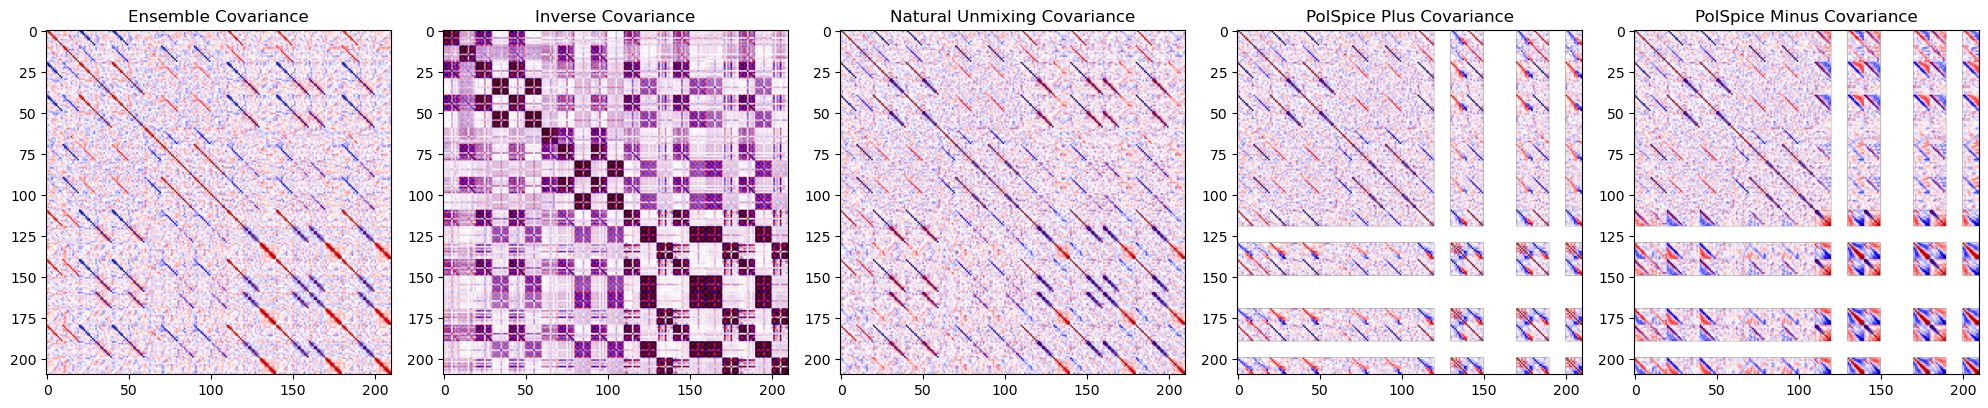

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(20, 15))

# Flattened Ensemble Covariance
im1 = axes[0].imshow(flat_ensemble_corr, cmap="seismic", vmin=-1, vmax=1)
axes[0].set_title("Ensemble Covariance")

# Flattened Inverse covariance
im2 = axes[1].imshow(flat_inv_ensemble_corr, cmap="seismic", vmin=-1, vmax=1)
axes[1].set_title("Inverse Covariance")

# Flattened Natural unmixing Covariance
im3 = axes[2].imshow(flat_nu_ensemble_corr, cmap="seismic", vmin=-1, vmax=1)
axes[2].set_title("Natural Unmixing Covariance")

# Flattened PolSpice Plus Covariance
im3 = axes[3].imshow(flat_pp_ensemble_corr, cmap="seismic", vmin=-1, vmax=1)
axes[3].set_title("PolSpice Plus Covariance")

# Flattened PolSpice Minus Covariance
im3 = axes[4].imshow(flat_pm_ensemble_corr, cmap="seismic", vmin=-1, vmax=1)
axes[4].set_title("PolSpice Minus Covariance")

plt.tight_layout()
plt.show()

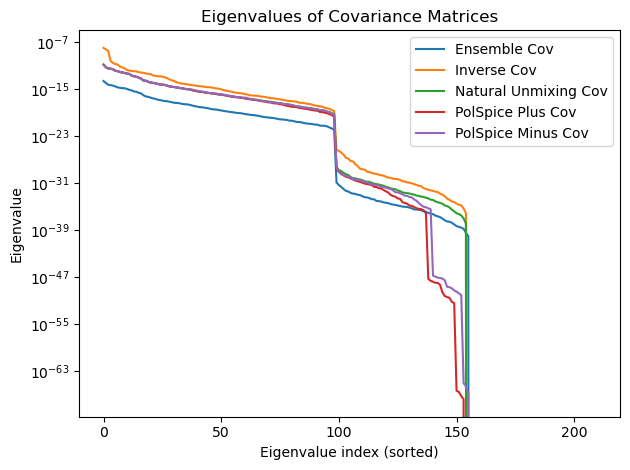

In [18]:
# Compute eigenvalues
eig_ens = np.linalg.eigvalsh(flat_ensemble_cov)
eig_inv_ens = np.linalg.eigvalsh(flat_inv_ensemble_cov)
eig_nu_ens = np.linalg.eigvalsh(flat_nu_ensemble_cov)
eig_pp_ens = np.linalg.eigvalsh(flat_pp_ensemble_cov)
eig_pm_ens = np.linalg.eigvalsh(flat_pm_ensemble_cov)

# Sort eigenvalues for plotting
eig_ens_sorted = np.sort(eig_ens)[::-1]
eig_inv_ens_sorted = np.sort(eig_inv_ens)[::-1]
eig_nu_ens_sorted = np.sort(eig_nu_ens)[::-1]
eig_pp_ens_sorted = np.sort(eig_pp_ens)[::-1]
eig_pm_ens_sorted = np.sort(eig_pm_ens)[::-1]

#plt.figure(figsize=(8, 6))
plt.semilogy(eig_ens_sorted, label='Ensemble Cov')
plt.semilogy(eig_inv_ens_sorted, label='Inverse Cov')
plt.semilogy(eig_nu_ens_sorted, label='Natural Unmixing Cov')
plt.semilogy(eig_pp_ens_sorted, label='PolSpice Plus Cov')
plt.semilogy(eig_pm_ens_sorted, label='PolSpice Minus Cov')
plt.xlabel('Eigenvalue index (sorted)')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Covariance Matrices')
plt.legend()
plt.tight_layout()
plt.show()

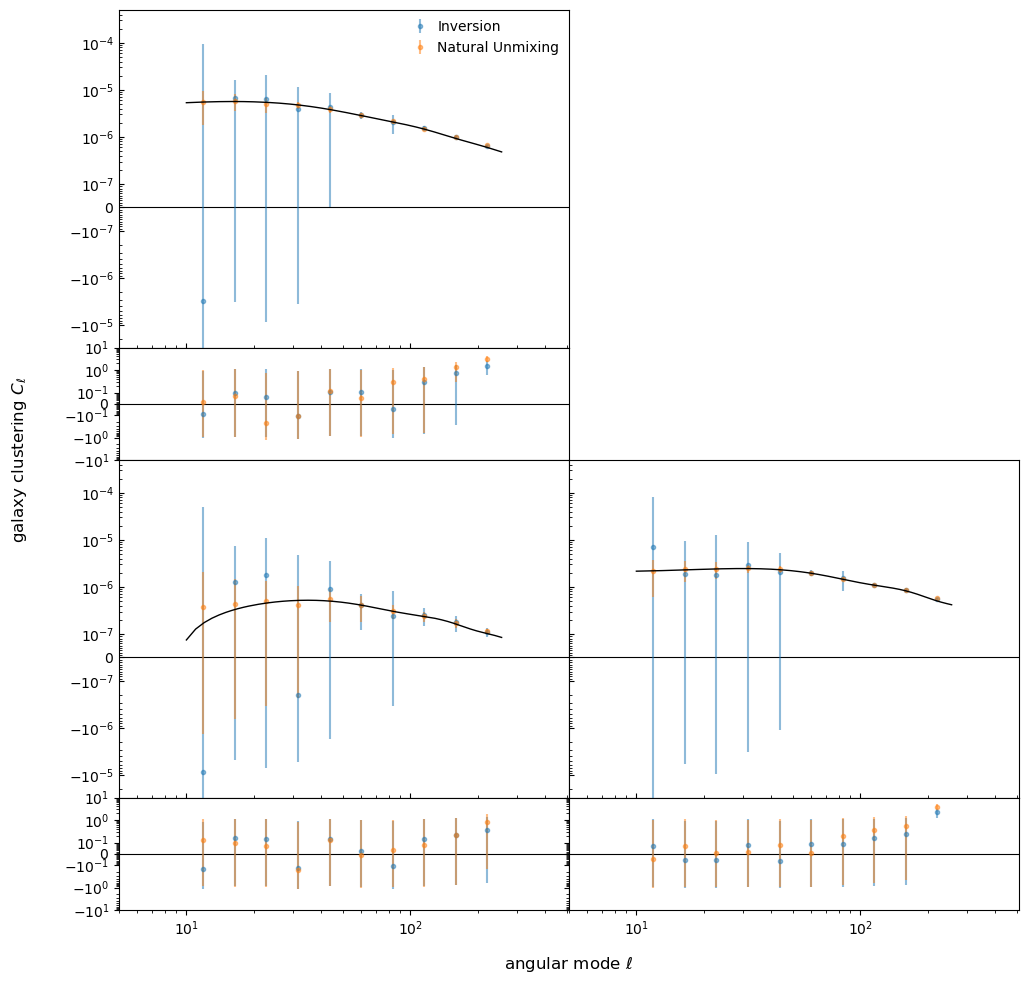

In [47]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    nbins - 1,
    figsize=(9, 9),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
        ax[j, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("POS", "POS", i, j)
        cov_key = ("POS", "POS", "POS", "POS", i, j, i, j)

        i_cov = i_ensemble_cov[cov_key]
        nu_cov = nu_ensemble_cov[cov_key]
        pp_cov = pp_ensemble_cov[cov_key]
        pm_cov = pm_ensemble_cov[cov_key]

        i_err = np.sqrt(np.diag(i_cov))
        nu_err = np.sqrt(np.diag(nu_cov))
        pp_err = np.sqrt(np.diag(pp_cov))
        pm_err = np.sqrt(np.diag(pm_cov))

        i_c = i_cqs_m[key]
        nu_c = nu_cqs_m[key]
        pp_c = pp_cqs_m[key]
        pm_c = pm_cqs_m[key]
        t = _theory_cls[key]
        t_itp = np.interp(lgrid, ls, t)

        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, i_c, yerr=i_err, fmt=".", c="C0", lw=1.5, zorder=3.0, alpha=0.5,
            label="Inversion"
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, nu_c, yerr=nu_err, fmt=".", c="C1", lw=1.5, zorder=3.0, alpha=0.5,
            label="Natural Unmixing"
        )
        ax[2 * (j - 1), i - 1].plot(ls[10:], t[10:], c="k", lw=1.0, zorder=4.0)
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (i_c - t_itp) / i_err,
            yerr=np.abs(i_err / i_err),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (nu_c - t_itp) / nu_err,
            yerr=np.abs(nu_err / nu_err),
            fmt=".",
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)

        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")
        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-3e-5, 5e-4)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog", linthresh=0.1, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-10, 10)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(5, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(5, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])
ax[0,0].legend(
    loc="upper right",
    fontsize=10,
    frameon=False,
    handlelength=1.5,
    handletextpad=0.5,
    borderpad=0.2,
)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

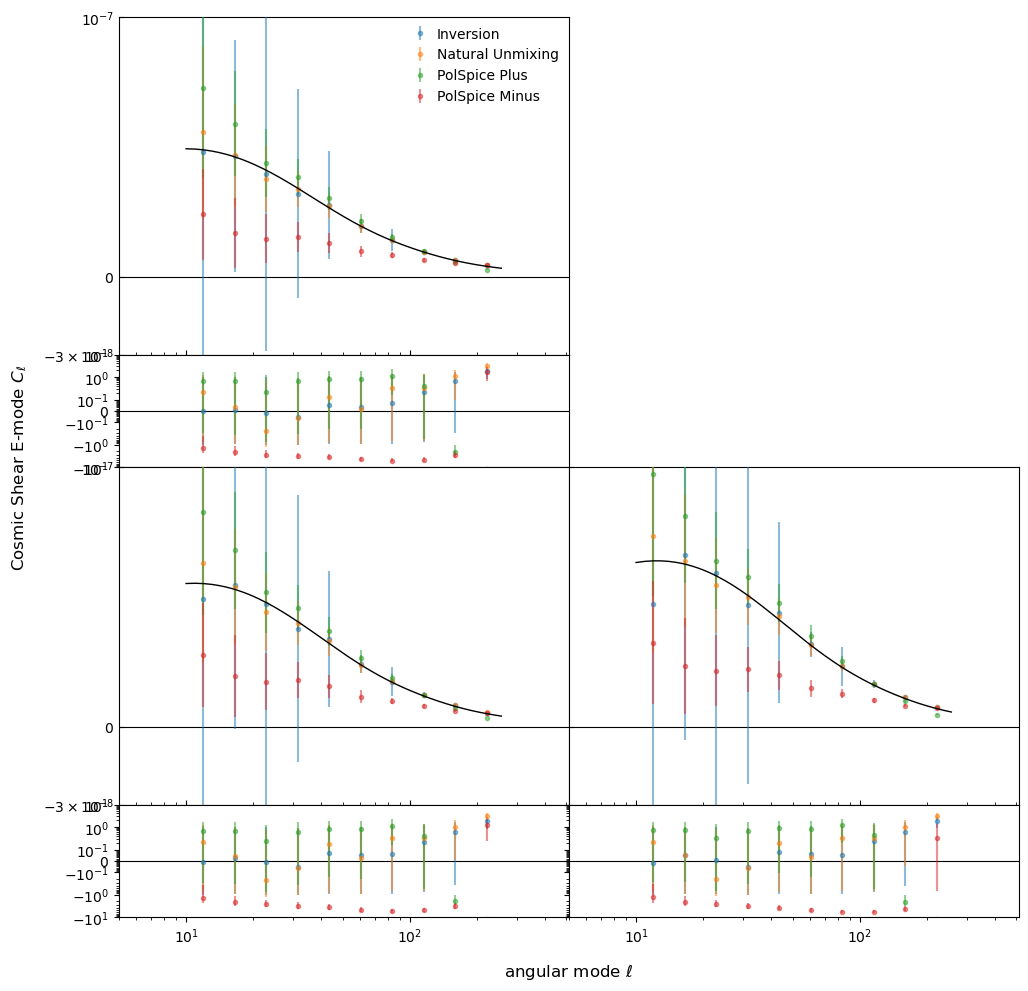

In [48]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    nbins - 1,
    figsize=(9, 9),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
        ax[j, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("SHE", "SHE", i, j)
        cov_key = ("SHE", "SHE", "SHE", "SHE", i, j, i, j)

        i_cov = i_ensemble_cov[cov_key][0, 0, 0, 0, :, :]
        nu_cov = nu_ensemble_cov[cov_key][0, 0, 0, 0, :, :]
        pp_cov = pp_ensemble_cov[cov_key][0, 0, 0, 0, :, :]
        pm_cov = pm_ensemble_cov[cov_key][0, 0, 0, 0, :, :]

        i_err = np.sqrt(np.diag(i_cov))
        nu_err = np.sqrt(np.diag(nu_cov))
        pp_err = np.sqrt(np.diag(pp_cov))
        pm_err = np.sqrt(np.diag(pm_cov))

        i_c = i_cqs_m[key][0, 0, :]
        nu_c = nu_cqs_m[key][0, 0, :]
        pp_c = pp_cqs_m[key][0, 0, :]
        pm_c = pm_cqs_m[key][0, 0, :]
        t = _theory_cls[key][0, 0, :]
        t_itp = np.interp(lgrid, ls, t)

        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, i_c, yerr=i_err, fmt=".", c="C0", lw=1.5, zorder=3.0, alpha=0.5,
            label="Inversion"
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, nu_c, yerr=nu_err, fmt=".", c="C1", lw=1.5, zorder=3.0, alpha=0.5,
            label="Natural Unmixing"
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, pp_c, yerr=pp_err, fmt=".", c="C2", lw=1.5, zorder=3.0, alpha=0.5,
            label="PolSpice Plus"
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, pm_c, yerr=pm_err, fmt=".", c="C3", lw=1.5, zorder=3.0, alpha=0.5,
            label="PolSpice Minus"
        )
        ax[2 * (j - 1), i - 1].plot(ls[10:], t[10:], c="k", lw=1.0, zorder=4.0)
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (i_c - t_itp) / i_err,
            yerr=np.abs(i_err / i_err),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (nu_c - t_itp) / nu_err,
            yerr=np.abs(nu_err / nu_err),
            fmt=".",
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (pp_c - t_itp) / pp_err,
            yerr=np.abs(pp_err / pp_err),
            fmt=".",
            c="C2",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (pm_c - t_itp) / pm_err,
            yerr=np.abs(pm_err / pm_err),
            fmt=".",
            c="C3",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)

        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")
        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-3e-8, 1e-7)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog", linthresh=0.1, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-10, 10)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(5, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(5, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])
ax[0,0].legend(
    loc="upper right",
    fontsize=10,
    frameon=False,
    handlelength=1.5,
    handletextpad=0.5,
    borderpad=0.2,
)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("Cosmic Shear E-mode $C_\\ell$", x=-0.1, ha="right")

plt.show()

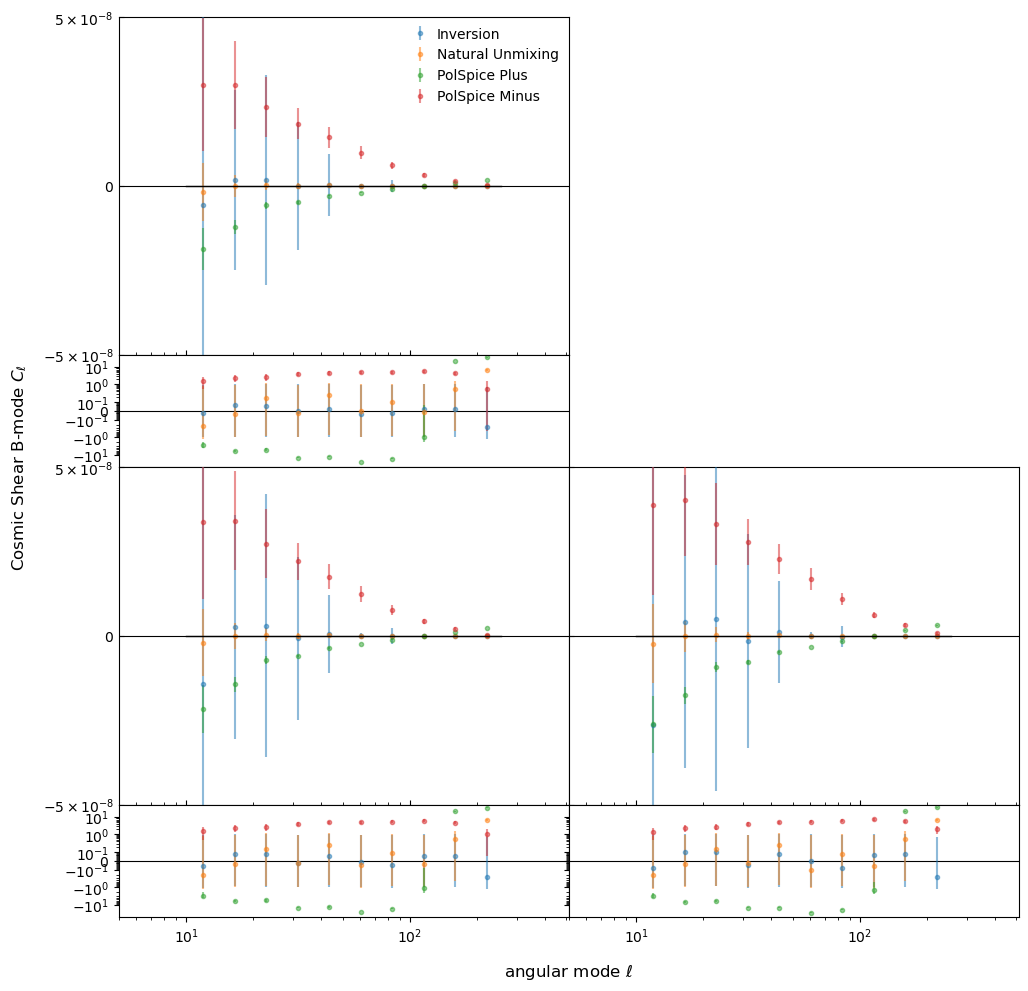

In [49]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    nbins - 1,
    figsize=(9, 9),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
        ax[j, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("SHE", "SHE", i, j)
        cov_key = ("SHE", "SHE", "SHE", "SHE", i, j, i, j)

        i_cov = i_ensemble_cov[cov_key][1, 1, 1, 1, :, :]
        nu_cov = nu_ensemble_cov[cov_key][1, 1, 1, 1, :, :]
        pp_cov = pp_ensemble_cov[cov_key][1, 1, 1, 1, :, :]
        pm_cov = pm_ensemble_cov[cov_key][1, 1, 1, 1, :, :]

        i_err = np.sqrt(np.diag(i_cov))
        nu_err = np.sqrt(np.diag(nu_cov))
        pp_err = np.sqrt(np.diag(pp_cov))
        pm_err = np.sqrt(np.diag(pm_cov))

        i_c = i_cqs_m[key][1, 1, :]
        nu_c = nu_cqs_m[key][1, 1, :]
        pp_c = pp_cqs_m[key][1, 1, :]
        pm_c = pm_cqs_m[key][1, 1, :]
        t = _theory_cls[key][1, 1, :]
        t_itp = np.interp(lgrid, ls, t)

        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, i_c, yerr=i_err, fmt=".", c="C0", lw=1.5, zorder=3.0, alpha=0.5,
            label="Inversion"
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, nu_c, yerr=nu_err, fmt=".", c="C1", lw=1.5, zorder=3.0, alpha=0.5,
            label="Natural Unmixing"
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, pp_c, yerr=pp_err, fmt=".", c="C2", lw=1.5, zorder=3.0, alpha=0.5,
            label="PolSpice Plus"
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, pm_c, yerr=pm_err, fmt=".", c="C3", lw=1.5, zorder=3.0, alpha=0.5,
            label="PolSpice Minus"
        )
        ax[2 * (j - 1), i - 1].plot(ls[10:], t[10:], c="k", lw=1.0, zorder=4.0)
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (i_c - t_itp) / i_err,
            yerr=np.abs(i_err / i_err),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (nu_c - t_itp) / nu_err,
            yerr=np.abs(nu_err / nu_err),
            fmt=".",
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (pp_c - t_itp) / pp_err,
            yerr=np.abs(pp_err / pp_err),
            fmt=".",
            c="C2",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (pm_c - t_itp) / pm_err,
            yerr=np.abs(pm_err / pm_err),
            fmt=".",
            c="C3",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)

        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")
        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-5e-8,5e-8)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog", linthresh=0.1, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-50, 50)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(5, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(5, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])
ax[0,0].legend(
    loc="upper right",
    fontsize=10,
    frameon=False,
    handlelength=1.5,
    handletextpad=0.5,
    borderpad=0.2,
)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("Cosmic Shear B-mode $C_\\ell$", x=-0.1, ha="right")

plt.show()